In [223]:
import sys
import numpy as np
import cv2
from time import sleep
from datetime import datetime
import os
import numpy as np
from matplotlib import pyplot as plt
from pandas import read_csv, read_excel, DataFrame
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
q = os.path.join('C:\\Users\\joaquin','usda','raw','CookIRCamET','Images','Cprl20220506')
p = os.path.join('C:\\Users\\joaquin','usda','raw','CookIRCamET','Images','Cprl20220512')
p2 = os.path.join('C:\\Users\\joaquin','usda','work','CookIRCamET','Images','Cprl20220512')
dilate=False

In [212]:
def quadrant(img_size,coord):
    if coord[0]>img_size[1]/2 and coord[1]>img_size[0]/2:
        return 1
    elif coord[0]>img_size[1]/2 and coord[1]<=img_size[0]/2:
        return 4
    elif coord[0]<=img_size[1]/2 and coord[1]>img_size[0]/2:
        return 2
    else:
        return 3

In [213]:
os.listdir(p)

['2022512171844_-102.096107_35.168660_bgr.png',
 '2022512171844_-102.096107_35.168660_ir.png',
 '2022512171846_-102.096152_35.168660_bgr.png',
 '2022512171846_-102.096152_35.168660_ir.png',
 '2022512171902_-102.096285_35.168698_bgr.png',
 '2022512171902_-102.096285_35.168698_ir.png',
 'Readme.xlsx']

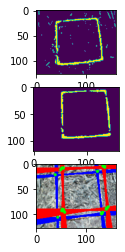

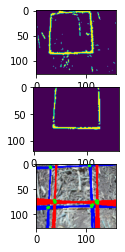

In [217]:
# find and draw the keypoints

srcXY, dstXY = [], []
n_img = 0
f_imgs = list()
for f in os.listdir(p):
    if 'bgr' in f and n_img<2:
        f_imgs = np.append(f_imgs,f)
        n_img = n_img + 1
        bgr = cv2.imread(os.path.join(p,f),cv2.IMREAD_UNCHANGED)
        hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
        lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
        img = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
        h,s,v = cv2.split(hsv)
        b,g,r = cv2.split(bgr)
        l,a,bb = cv2.split(lab)
        
        f_ir = f.split('_bgr')[0]+'_ir.png'
        ir = cv2.imread(os.path.join(p,f_ir),cv2.IMREAD_UNCHANGED)
        cv2.normalize(ir, ir, 0, 65535, cv2.NORM_MINMAX)
        #cv2.normalize(v, v, 0, 65535, cv2.NORM_MINMAX)
        
        ir=np.flip(np.uint8(np.right_shift(ir, 8, ir)))        
        
        # Otsu's thresholding
        _,v = cv2.threshold(v,220,255,cv2.THRESH_BINARY)
        _,ir = cv2.threshold(ir,120,255,cv2.THRESH_BINARY_INV)
        
        if dilate:
            kernel = np.ones((3,3),np.uint8)
            v = cv2.erode(v,kernel,iterations = 1)
            kernel = np.ones((3,3),np.uint8)
            ir = cv2.erode(ir,kernel,iterations = 1)

            kernel = np.ones((3,3),np.uint8)
            v = cv2.dilate(v,kernel,iterations = 2)
            kernel = np.ones((3,3),np.uint8)
            ir = cv2.dilate(ir,kernel,iterations = 2)
              
        line_params_v={'slope':[],'intercept':[]}
        lines_v = cv2.HoughLines(v,1,np.pi/180,75)
        slope = np.zeros(lines_v.shape[0])
        intercept = np.zeros(lines_v.shape[0])
        four_v = np.zeros((lines_v.shape[0],4))
        ii = 0
        for line in lines_v:
            rho,theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 200*(-b))
            y1 = int(y0 + 200*(a))
            x2 = int(x0 - 200*(-b))
            y2 = int(y0 - 200*(a))
            cv2.line(bgr,(x1,y1),(x2,y2),(0,0,255),2)
            four_v[ii,:]=np.array([x1,y1,x2,y2])
            if x2==x1:
                slope[ii]=(y2-y1)/(x2-x1+.0000001*np.random.randn(1))
            else:
                slope[ii]=(y2-y1)/(x2-x1)
            intercept[ii]=(y2-slope[ii]*x2)
            ii = ii+1
            
        line_params_v['slope']=slope
        line_params_v['intercept']=intercept
        
        lines_ir = cv2.HoughLines(ir,1,np.pi/180,50)
        line_params_ir={'slope':[],'intercept':[]}
        slope = np.zeros(lines_ir.shape[0])
        intercept = np.zeros(lines_ir.shape[0])
        four_ir = np.zeros((lines_ir.shape[0],4))
        ii = 0
        for line in lines_ir:
            rho,theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 200*(-b))
            y1 = int(y0 + 200*(a))
            x2 = int(x0 - 200*(-b))
            y2 = int(y0 - 200*(a))
            cv2.line(bgr,(x1,y1),(x2,y2),(255,0,0),2)
            four_ir[ii,:]=np.array([x1,y1,x2,y2])
            if x2==x1:
                slope[ii]=(y2-y1)/(x2-x1+.0000001*np.random.randn(1))
            else:
                slope[ii]=(y2-y1)/(x2-x1)
            intercept[ii]=(y2-slope[ii]*x2)
            ii = ii+1
        line_params_ir['slope']=slope
        line_params_ir['intercept']=intercept

        n = line_params_v['slope'].shape[0]
        combos = int((n*(n-1))/2)
        corner_v = np.zeros((combos,2))
        kk = 0
        for ii in range(line_params_v['slope'].shape[0]):
            for jj in range(ii,line_params_v['slope'].shape[0]):
                if ii!=jj:
                    if np.abs(np.abs(line_params_v['slope'][ii])*np.abs(line_params_v['slope'][jj])-1)<.1:
                        x = (line_params_v['intercept'][jj]-line_params_v['intercept'][ii])/(line_params_v['slope'][ii]-line_params_v['slope'][jj])
                        y = line_params_v['slope'][ii]*x+line_params_v['intercept'][ii]
                        corner_v[kk,0] = x
                        corner_v[kk,1] = y
                        kk = kk+1
                        try:
                            cv2.circle(bgr, (int(x),int(y)), radius=3, color=(0, 255, 0), thickness=-1)
                        except:
                            pass
                    else:
                        x = np.nan
                        y = np.nan
                        corner_v[kk,0] = x
                        corner_v[kk,1] = y
                        kk = kk+1
        n = line_params_ir['slope'].shape[0]
        combos = int((n*(n-1))/2)
        corner_ir = np.zeros((combos,2))
        kk = 0
        for ii in range(line_params_ir['slope'].shape[0]):
            for jj in range(ii,line_params_ir['slope'].shape[0]):
                if ii!=jj:
                    if np.abs(np.abs(line_params_ir['slope'][ii])*np.abs(line_params_ir['slope'][jj])-1)<.1:
                        x = (line_params_ir['intercept'][jj]-line_params_ir['intercept'][ii])/(line_params_ir['slope'][ii]-line_params_ir['slope'][jj])
                        y = line_params_ir['slope'][ii]*x+line_params_ir['intercept'][ii]
                        corner_ir[kk,0] = x
                        corner_ir[kk,1] = y
                        kk = kk+1
                        try:
                            cv2.circle(bgr, (int(x),int(y)), radius=3, color=(0, 255, 0), thickness=-1)
                        except:
                            pass
                    else:
                        x = np.nan
                        y = np.nan
                        corner_ir[kk,0] = x
                        corner_ir[kk,1] = y
                        kk = kk+1
        
        corner_ir = corner_ir[np.argwhere(np.isnan(corner_ir[:,0])==False)[:,0],]
        corner_v = corner_v[np.argwhere(np.isnan(corner_v[:,0])==False)[:,0],]


        q_v = np.zeros(corner_v.shape[0])
        q_ir = np.zeros(corner_ir.shape[0])
        for ii in range(corner_v.shape[0]):
            q_v[ii] = quadrant(bgr.shape[0:2],corner_v[ii,:])    
        for jj in range(corner_ir.shape[0]):
            q_ir[jj] = quadrant(ir.shape[0:2],corner_ir[jj,:])

      
        for ii in range(corner_v.shape[0]):
            for jj in range(corner_ir.shape[0]):
                if q_v[ii]==q_ir[jj]:
                    srcXY.append(corner_ir[jj,:])
                    dstXY.append(corner_v[ii,:])
        
        
        plt.subplot(311)
        plt.imshow(v)
        plt.subplot(312)
        plt.imshow(ir)
        plt.subplot(313)
        plt.imshow(bgr)
        plt.show()
        

In [218]:
srcXY = np.float32(np.array(srcXY))
dstXY = np.float32(np.array(dstXY))
warp_mat = cv2.estimateAffine2D(srcXY,dstXY)

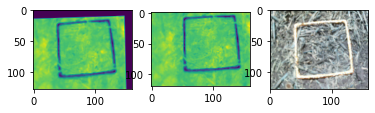

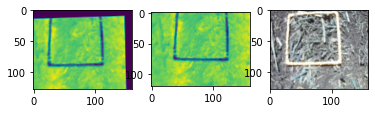

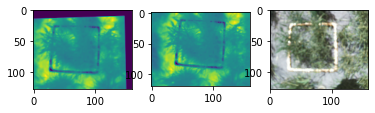

In [221]:
n_img = 0
f_imgs = list()
for f in os.listdir(p):
    if 'bgr' in f:
        f_imgs = np.append(f_imgs,f)
        n_img = n_img + 1
        bgr = cv2.imread(os.path.join(p,f),cv2.IMREAD_UNCHANGED)
        f_ir = f.split('_bgr')[0]+'_ir.png'
        ir = cv2.imread(os.path.join(p,f_ir),cv2.IMREAD_UNCHANGED)
        cv2.normalize(ir, ir, 0, 65535, cv2.NORM_MINMAX)
        #cv2.normalize(v, v, 0, 65535, cv2.NORM_MINMAX)
        
        ir=np.flip(np.uint8(np.right_shift(ir, 8, ir)))
        warp_dst = cv2.warpAffine(ir, warp_mat[0], (v.shape[1], v.shape[0]))   
        plt.subplot(131)
        plt.imshow(warp_dst)
        plt.subplot(132)
        plt.imshow(ir)
        plt.subplot(133)
        plt.imshow(bgr)
        plt.show()

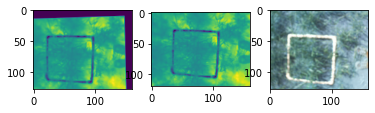

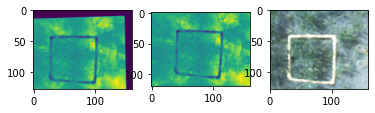

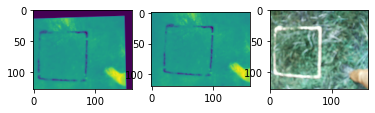

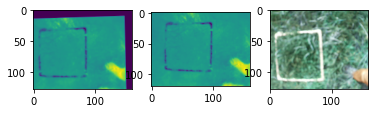

In [227]:
n_img = 0
f_imgs = list()
for f in os.listdir(q):
    if 'bgr' in f:
        f_imgs = np.append(f_imgs,f)
        n_img = n_img + 1
        bgr = cv2.imread(os.path.join(q,f),cv2.IMREAD_UNCHANGED)
        f_ir = f.split('_bgr')[0]+'_ir.png'
        ir = cv2.imread(os.path.join(q,f_ir),cv2.IMREAD_UNCHANGED)
        cv2.normalize(ir, ir, 0, 65535, cv2.NORM_MINMAX)
        #cv2.normalize(v, v, 0, 65535, cv2.NORM_MINMAX)
        
        ir=np.flip(np.uint8(np.right_shift(ir, 8, ir)))
        warp_dst = cv2.warpAffine(ir, warp_mat[0], (v.shape[1], v.shape[0]))   
        plt.subplot(131)
        plt.imshow(warp_dst)
        plt.subplot(132)
        plt.imshow(ir)
        plt.subplot(133)
        plt.imshow(bgr)
        plt.show()

In [226]:
ir